<a href="https://colab.research.google.com/github/HelenGuohx/Quora-Insincere-Questions/blob/master/qiqc_baseline_biGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [112]:
!kaggle competitions download -c quora-insincere-questions-classification

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
embeddings.zip: Skipping, found more recently modified local copy (use --force to force download)
User cancelled operation


In [113]:
!unzip embeddings.zip -d embeddings

Archive:  embeddings.zip
replace embeddings/glove.840B.300d/glove.840B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [114]:
import os
import gc
import re
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import string

from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold


In [115]:
def seed_everything(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [116]:
def tokenize_sentence(sentences, max_features,maxlen):
    """
    sentences: string 
    max_features: int, maximum number of words
    return: sentences, a list of indices
            word_index, a dict of word and index pair
    """
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(sentences)
    sentences = tokenizer.texts_to_sequences(sentences)
    ## Pad the sentences 
    sentences = pad_sequences(sentences, maxlen=maxlen, padding="post", truncating="post")
    return sentences, tokenizer.word_index

### Word Embedding

In [139]:
def load_embedding(typeToLoad):
    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float16')
    embeddings_index = {}
    if typeToLoad == "glove":
        file = 'embeddings/glove.840B.300d/glove.840B.300d.txt'
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    elif typeToLoad == "word2vec":
        file = 'embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
        embeddings_index = KeyedVectors.load_word2vec_format(file, binary=True)  # query word vector from the file
    elif typeToLoad == "fasttext":
        file = 'embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    elif typeToLoad == "paragram":
        file = 'embeddings/paragram_300_sl999/paragram_300_sl999.txt'
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding = "utf8", errors='ignore') )
    return embeddings_index

def make_embedding_matrix(embeddings_index, word_index, max_words):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(dtype=float), all_embs.std(dtype=float) #return std=-inf, sol:convert dtype=np.float16 to float64
    embed_size = all_embs.shape[1]
    num_word = min(max_words, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (num_word, embed_size)) #init embedding matrix
    for word, index in word_index.items():
      if index >= max_words: continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None: embedding_matrix[index] = embedding_vector
    return embedding_matrix


### Data cleaning

In [118]:
%%time
spaces = ['\u200b', '\u200e', '\u202a', '\u202c', '\ufeff', '\uf0d8', '\u2061', '\x10', '\x7f', '\x9d', '\xad', '\xa0']

# with open('src/rare_words.json') as f:
#      rare_words_mapping = json.load(f)

# with open('src/misspell_words.json') as f:
#      misspell_words_mapping = json.load(f)

# stop_words = stopwords.words('english')

# replace unicode space character with space ' '
def replace_space(text):
    for s in spaces:
        text = text.replace(s, ' ')
    return text

def clean_rare_words(text):
    for w in rare_words_mapping:
        if text.count(w) > 0:
            text = text.replace(w, rare_words_mapping[w])
    return text

def clean_decontracted(text):
    # specific
    text = re.sub(r"(W|w)on(\'|\’)t ", "will not ", text)
    text = re.sub(r"(C|c)an(\'|\’)t ", "can not ", text)
    text = re.sub(r"(Y|y)(\'|\’)all ", "you all ", text)
    text = re.sub(r"(Y|y)a(\'|\’)ll ", "you all ", text)

    # general
    text = re.sub(r"(I|i)(\'|\’)m ", "i am ", text)
    text = re.sub(r"(A|a)in(\'|\’)t ", "is not ", text)
    text = re.sub(r"n(\'|\’)t ", " not ", text)
    text = re.sub(r"(\'|\’)re ", " are ", text)
    text = re.sub(r"(\'|\’)s ", " is ", text)
    text = re.sub(r"(\'|\’)d ", " would ", text)
    text = re.sub(r"(\'|\’)ll ", " will ", text)
    text = re.sub(r"(\'|\’)t ", " not ", text)
    text = re.sub(r"(\'|\’)ve ", " have ", text)
    return text


def clean_misspell(text):
    for w in misspell_words_mapping:
        if text.count(w) > 0:
            text = text.replace(w, misspell_words_mapping[w])
    return text


# replace punctuation with space
def replace_punctuation(text):
    punct = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    return text.translate(punct)


# clean repeated letters
def clean_repeat_words(text):
    text = text.replace("img", "ing")
    text = re.sub(r"(I|i)(I|i)+ng", "ing", text)
    text = re.sub(r"(L|l)(L|l)(L|l)+y", "lly", text)
    text = re.sub(r"(A|a)(A|a)(A|a)+", "a", text)
    text = re.sub(r"(C|c)(C|c)(C|c)+", "cc", text)
    text = re.sub(r"(D|d)(D|d)(D|d)+", "dd", text)
    text = re.sub(r"(E|e)(E|e)(E|e)+", "ee", text)
    text = re.sub(r"(F|f)(F|f)(F|f)+", "ff", text)
    text = re.sub(r"(G|g)(G|g)(G|g)+", "gg", text)
    text = re.sub(r"(I|i)(I|i)(I|i)+", "i", text)
    text = re.sub(r"(K|k)(K|k)(K|k)+", "k", text)
    text = re.sub(r"(L|l)(L|l)(L|l)+", "ll", text)
    text = re.sub(r"(M|m)(M|m)(M|m)+", "mm", text)
    text = re.sub(r"(N|n)(N|n)(N|n)+", "nn", text)
    text = re.sub(r"(O|o)(O|o)(O|o)+", "oo", text)
    text = re.sub(r"(P|p)(P|p)(P|p)+", "pp", text)
    text = re.sub(r"(Q|q)(Q|q)+", "q", text)
    text = re.sub(r"(R|r)(R|r)(R|r)+", "rr", text)
    text = re.sub(r"(S|s)(S|s)(S|s)+", "ss", text)
    text = re.sub(r"(T|t)(T|t)(T|t)+", "tt", text)
    text = re.sub(r"(V|v)(V|v)+", "v", text)
    text = re.sub(r"(Y|y)(Y|y)(Y|y)+", "y", text)
    text = re.sub(r"plzz+", "please", text)
    text = re.sub(r"(Z|z)(Z|z)(Z|z)+", "zz", text)
    return text


def lower_words(text):
    return text.lower()

def remove_stopwords(text):
    words = text.split()
    new_words = []
    for w in words:
        if w not in stop_words and w != ' ':
            new_words.append(w)
    return ' '.join(new_words)

def stemming(text):
    pass

# apply all the clean methods
def text_cleaning(text):
    text = replace_space(text)
    text = clean_decontracted(text)
    text = replace_punctuation(text)
    text = lower_words(text)
    text = clean_repeat_words(text)
    # text = clean_rare_words(text)
    # text = clean_misspell(text)
    # text = remove_stopwords(text)
    return text

CPU times: user 337 µs, sys: 1 µs, total: 338 µs
Wall time: 347 µs


### statistic feactures

### Modeling

In [143]:
class GRU_Net(nn.Module):
  def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, num_directions=2, dropout=0.5, fix_embedding=True):
    super(GRU_Net, self).__init__()
    self.embedding = nn.Embedding(embedding.size(0),embedding.size(1))
    self.embedding.weight = torch.nn.Parameter(embedding)
    self.embedding.weight.requires_grad = False if fix_embedding else True
    self.gru = nn.GRU(embedding_dim, 
                      hidden_dim, 
                      num_layers=num_layers, 
                      batch_first=True, #input and output (batch, seq, feature)
                      bidirectional = num_directions == 2
                      )
    self.classifier = nn.Sequential( nn.Dropout(dropout),
                                         nn.Linear(hidden_dim*num_directions, 1),
                                         nn.Sigmoid() ) #softmax
  def forward(self, input):
    input = self.embedding(input)
    # input = torch.tensor(input.clone().detach(), dtype=torch.float32)
    output, _ = self.gru(input) #input, h0 Defaults to zero
    output = self.classifier(output[:, -1, :])
    return output

In [120]:
class MyDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = X
        self.label = y
    def __getitem__(self, idx):
        if self.label is None: return self.data[idx]
        return self.data[idx], self.label[idx]
    def __len__(self):
        return len(self.data)

### Training

In [121]:
def training(batch_size, n_epoch, lr, model_dir, train, valid, model, device):
    criterion = nn.BCEWithLogitsLoss()#nn.BCELoss() #binary cross entropy loss function 
    t_batch = len(train) 
    v_batch = len(valid) 
    optimizer = optim.Adam(model.parameters(), lr=lr) # 
    for epoch in range(n_epoch):
        # training module
        model.train() # training mode, weights are updated
        total_loss = 0
        for i, (inputs, labels) in enumerate(train):
            inputs = inputs.to(device, dtype=torch.long) 
            labels = labels.to(device, dtype=torch.float) 
            optimizer.zero_grad() 
            outputs = model(inputs) 
            outputs = outputs.squeeze() 
            loss = criterion(outputs, labels) # compute training loss
            loss.backward() # 算 loss 的 gradient
            optimizer.step() 
            total_loss += loss.item()
            print('[ Epoch{}: {}/{} ] loss:{:.3f}'.format(
            	epoch+1, i+1, t_batch, loss.item(), end='\r'))
        print('\nEpoch{}: Train | Loss:{:.5f}'.format(epoch+1, total_loss/t_batch))

        # validation module
        model.eval() # fixed weights
        with torch.no_grad(): #disables tracking of gradients in autograd.
            total_loss, best_loss = 0, 0
            for i, (inputs, labels) in enumerate(valid):
                inputs = inputs.to(device, dtype=torch.long) 
                labels = labels.to(device, dtype=torch.float) 
                outputs = model(inputs) 
                outputs = outputs.squeeze() 
                loss = criterion(outputs, labels) 
                total_loss += loss.item()

            print("\nEpoch{}: Valid | Loss:{:.5f}".format(epoch+1, total_loss/v_batch))
            curr_loss = total_loss/v_batch
            if curr_loss < best_loss:
                best_loss = curr_loss
                torch.save(model, "{}/qiqc.model".format(model_dir))
                print('saving model with Loss:{:.5f}'.format(total_loss/v_batch))
        print('-----------------------------------------------')

### test

In [122]:
def testing(batch_size, test_loader, model, device):
    model.eval()
    with torch.no_grad():
        for i, inputs in enumerate(tqdm(test_loader)):
            inputs = inputs.to(device, dtype=torch.long)
            outputs = model(inputs)
            outputs = outputs.squeeze(0) #squeeze removes all demensions with input size of 1, squeeze(0) only 
    return outputs

In [124]:
def find_best_threshold(y_true,output):
    best_score = 0 # threshold, score, best_score
    threshold = 0
    for t in tqdm(np.arange(0.1, 0.501, 0.01)):
        score = f1_score(y_true, np.array(output)>t)
        if score > best_score:
            threshold = t
            best_score = score
    print('best threshold is {:.4f} with F1 score: {:.4f}'.format(threshold, best_score))
    return threshold, best_score

### Main

In [125]:
from tqdm.gui import tqdm as tqdm_gui
tqdm_gui.pandas()

Loading training data


/usr/local/lib/python3.6/dist-packages/tqdm/std.py:726: TqdmExperimentalWarning: GUI is experimental/alpha
  t = tclass(*targs, total=total, **tkwargs)


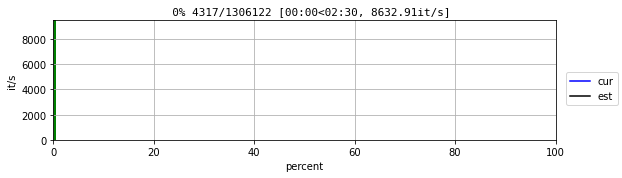

CPU times: user 5min 41s, sys: 6.75 s, total: 5min 47s
Wall time: 5min 48s


In [126]:
%%time
# hyperparameters
seed = 888
kfold = 10
batch_size = 128
n_workers = 8
n_epoch = 5
hidden_dim = 150
n_layers = 1
max_words = 120000
embedding_dim = 300
lr = 0.001

seed_everything(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Loading training data")
train_df = pd.read_csv("train.csv.zip")

train_x = train_df["question_text"].progress_apply(text_cleaning).values

train_x, word_index = tokenize_sentence(train_x, max_words, maxlen=70)
y = train_df['target'].values
glove_embedding = load_embedding("glove")
#embedding_matrix = np.mean([glove_embeddings, paragram_embeddings], axis=0)
embedding_matrix = make_embedding_matrix(glove, word_index, max_words)
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [16]:
del train_df
del glove_embedding
del word_index
gc.collect()

0

In [150]:
# embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
batch_size = 128


In [152]:
results = []
skf = StratifiedKFold(kfold, shuffle=True, random_state=seed)
for i, (train_index, test_index) in enumerate(skf.split(train_x[:100000], y[:100000])):
    if i >= 5: break
    print("---- cv", i)
    X_train = torch.tensor(train_x[train_index], dtype=torch.long)
    y_train = torch.tensor(y[train_index], dtype=torch.float)
    X_test  = torch.tensor(train_x[test_index], dtype=torch.long)
    y_test  = torch.tensor(y[test_index], dtype=torch.float)
    
    train_dataset = MyDataset(X_train, y_train)
    val_len = int(len(test_index) * 0.1)
    val_index = np.random.choice(test_index, val_len, replace=False) 
    val_dataset = MyDataset(train_x[val_index], y[val_index])
    print("train size {}, validation size {}".format(len(train_dataset), len(val_dataset)))

    train_loader = DataLoader(dataset = train_dataset,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                num_workers = n_workers)
    val_loader = DataLoader(dataset = val_dataset,
                                                batch_size = batch_size,
                                                shuffle = False,
                                                num_workers = n_workers)
    
    model = GRU_Net(embedding_matrix, \
                    embedding_dim,
                    hidden_dim=hidden_dim, num_layers=n_layers, num_directions=2, dropout=0.5, fix_embedding=True)
    model = model.to(device) 
    
    print("Training")
    model_dir = f"model_cv{i}/"
    training(batch_size, n_epoch, lr, model_dir, train_loader, val_loader, model, device)
    
    del train_dataset
    del train_loader
    del val_loader 
    del val_dataset
    gc.collect()

    print('\nload model ...')
    model = torch.load(os.path.join(model_dir, "qiqc.model"))
    print("Testing")
    test_dataset = MyDataset(X_test)
    test_loader = DataLoader(dataset = test_dataset,
                                                batch_size = batch_size,
                                                shuffle = False,
                                                num_workers = n_workers)
    outputs = testing(batch_size, test_loader, model, device)
    result.append(find_best_threshold(y_test,outputs))

    del test_dataset
    del test_loader
    gc.collect()
    break


---- cv 0
train size 90000, validation size 1000
Training
[ Epoch1: 1/704 ] loss:0.968
[ Epoch1: 2/704 ] loss:0.833
[ Epoch1: 3/704 ] loss:0.767
[ Epoch1: 4/704 ] loss:0.735
[ Epoch1: 5/704 ] loss:0.713
[ Epoch1: 6/704 ] loss:0.706
[ Epoch1: 7/704 ] loss:0.700
[ Epoch1: 8/704 ] loss:0.698
[ Epoch1: 9/704 ] loss:0.696
[ Epoch1: 10/704 ] loss:0.695
[ Epoch1: 11/704 ] loss:0.695
[ Epoch1: 12/704 ] loss:0.694
[ Epoch1: 13/704 ] loss:0.694
[ Epoch1: 14/704 ] loss:0.694
[ Epoch1: 15/704 ] loss:0.694
[ Epoch1: 16/704 ] loss:0.694
[ Epoch1: 17/704 ] loss:0.694
[ Epoch1: 18/704 ] loss:0.694
[ Epoch1: 19/704 ] loss:0.694
[ Epoch1: 20/704 ] loss:0.694
[ Epoch1: 21/704 ] loss:0.693
[ Epoch1: 22/704 ] loss:0.694
[ Epoch1: 23/704 ] loss:0.693
[ Epoch1: 24/704 ] loss:0.693
[ Epoch1: 25/704 ] loss:0.693
[ Epoch1: 26/704 ] loss:0.693
[ Epoch1: 27/704 ] loss:0.693
[ Epoch1: 28/704 ] loss:0.693
[ Epoch1: 29/704 ] loss:0.693
[ Epoch1: 30/704 ] loss:0.693
[ Epoch1: 31/704 ] loss:0.693
[ Epoch1: 32/704 ] lo

FileNotFoundError: ignored